In [1]:
from jwst_wcs_align import jwst_wcs_align
import re
from jwst_wcs_align import initplot, rotate_d_and_find_binmax, sigmacut_d_rot, infoplots
import matplotlib.pyplot as plt


input_image='/Users/arest/nircam/jwst_fpa_merged/data/nircam/01018/jw01018003001_02101_00001_nrca1_cal.fits'
input_image='/Users/arest/nircam/jwst_fpa_merged/data/nircam/01018/jw01018003001_02101_00001_nrca2_cal.fits'
distortion_file = 'final_CRDS/v1.2/nrca2_full_f200w_clear.distcoeff.asdf'

# test/test_wcsalign/jw01073003001_02101_00001_nrca1_assignwcsstep.fits

outrootdir = '.'
outsubdir = 'test_jwst_wcs_align'

overwrite = True
skip_applydistortions_if_exists=False
skip_if_exists = False
#refcatname = './LMC_gaia_DR3.nrcposs'
refcatname = 'gaia'
refcat_racol = None # if None, then set automatically
refcat_deccol = None # if None, then set automatically
pmflag = False
pm_median = True
photfilename = 'auto'
load_photcat_if_exists = False
rematch_refcat = False
use_dq=False
DNunits=True
SNR_min = 10
d2d_max = None # maximum distance refcat to source in image
dmag_max = 0.1 # maximum uncertainty of source 
Nbright= 600  # U/se only the brightest Nbright sources from image
# showplots=0: no plots
# showplots=1: important plots
# showplots=2: all plots
# showplots=3: debug plots
showplots=2
saveplots=1
savephottable=2
verbose=2

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-045-003 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-051
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf
Created TAP+ (v20200428.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v20200428.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
wcs_align = jwst_wcs_align()
wcs_align.verbose=verbose
wcs_align.set_outdir(outrootdir, outsubdir)


'./test_jwst_wcs_align'

In [3]:
# apply distortion coefficients if wanted.
# the output file with the new distortions has the suffix _assignwcsstep.fits
if distortion_file is not None:
    # apply distortion terms
    (runflag,calimname) = wcs_align.run_applydistortions(input_image,
                                                    distortion_file,
                                                    overwrite = overwrite, 
                                                    skip_if_exists = (skip_applydistortions_if_exists |  skip_if_exists))
else:
    calimname = input_image
print('Done!')

2022-06-14 13:18:27,951 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2022-06-14 13:18:28,037 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args ('/Users/arest/nircam/jwst_fpa_merged/data/nircam/01018/jw01018003001_02101_00001_nrca2_cal.fits',).
2022-06-14 13:18:28,039 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './test_jwst_wcs_align', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


This is NOT a rate.fits file! Therefore just applying the distortions with AssignWcsStep
assigning WCS to file /Users/arest/nircam/jwst_fpa_merged/data/nircam/01018/jw01018003001_02101_00001_nrca2_cal.fits using distortion file final_CRDS/v1.2/nrca2_full_f200w_clear.distcoeff.asdf
Setting output directory for assignwcsstep.fits file to ./test_jwst_wcs_align
WARNING! ./test_jwst_wcs_align/jw01018003001_02101_00001_nrca2_assignwcsstep.fits exists, deleting it since "overwrite" is set!
Creating ./test_jwst_wcs_align/jw01018003001_02101_00001_nrca2_assignwcsstep.fits


2022-06-14 13:18:32,146 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  80.499125908 -69.534818435 80.528548820 -69.549015216 80.569002967 -69.538873898 80.539938660 -69.524540562
2022-06-14 13:18:32,147 - stpipe.AssignWcsStep - INFO - assign_wcs updated S_REGION to POLYGON ICRS  80.499125908 -69.534818435 80.528548820 -69.549015216 80.569002967 -69.538873898 80.539938660 -69.524540562
2022-06-14 13:18:32,147 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs
2022-06-14 13:18:32,782 - stpipe.AssignWcsStep - INFO - Saved model in ./test_jwst_wcs_align/jw01018003001_02101_00001_nrca2_assignwcsstep.fits
2022-06-14 13:18:32,782 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


distortions applied to ./test_jwst_wcs_align/jw01018003001_02101_00001_nrca2_assignwcsstep.fits!!
Done!


In [4]:
# do the photometry
# you can speed this up if the photometry already exists with load_photcat_if_exists=True
# if you want to rematch teh refcat catalog even if load_photcat_if_exists, set rematch_refcat=True
# the photometry is a pandas table in self.phot.t
# the main columns are x,y
# if refcatname!=None, then a refcat is matched to the x,y positions.
# refcatname='gaia': Gaia photometry is obtained through Gaia API
# refcatname='./LMC_gaia_DR3.nrcposs': LMC catalog by Vera Platais
# refcatname=filename: custom catalog, but need to make sure 
# simple_jwst_phot.load_refcat and simple_jwst_phot.init_refcat know what to do,
# in particular with racol and deccol
wcs_align.phot.verbose = wcs_align.verbose
wcs_align.phot.run_phot(calimname,
                      refcatname=refcatname,
                      refcat_racol=refcat_racol,
                      refcat_deccol=refcat_deccol,
                      pmflag=pmflag,
                      pm_median=pm_median,
                      photfilename=photfilename,
                      load_photcat_if_exists=load_photcat_if_exists,
#                      load_photcat_if_exists=True,
                      rematch_refcat=rematch_refcat,
                      overwrite=overwrite,
                      use_dq = use_dq,
                      DNunits=DNunits,
                      SNR_min=SNR_min)
print('Done!')


### Doing photometry on ./test_jwst_wcs_align/jw01018003001_02101_00001_nrca2_assignwcsstep.fits
photometry catalog filename: ./test_jwst_wcs_align/jw01018003001_02101_00001_nrca2_assignwcsstep.phot.txt
photcat ./test_jwst_wcs_align/jw01018003001_02101_00001_nrca2_assignwcsstep.phot.txt already exists, but recreating it since overwrite=True
Filename: ./test_jwst_wcs_align/jw01018003001_02101_00001_nrca2_assignwcsstep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     346   ()      
  1  SCI           1 ImageHDU       112   (2048, 2048)   float32   
  2  ERR           1 ImageHDU        10   (2048, 2048)   float32   
  3  DQ            1 ImageHDU        11   (2048, 2048)   int32 (rescales to uint32)   
  4  AREA          1 ImageHDU         9   (2048, 2048)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (2048, 2048)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (2048, 2048)   float32   
  7  VAR_FLAT      1 ImageHDU   

2022-06-14 13:18:35,980 - stpipe - WARNING - /Users/arest/anaconda/envs/jwst/lib/python3.8/site-packages/astropy/stats/sigma_clipping.py:411: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn('Input data contains invalid values (NaNs or '



None
Instrument: NIRCAM, aperture:NRCA2_FULL
Applying Pixel Area Map
Converting units from MJy/sr to DN/s
Finding stars --- Detector: NRCA2, Filter: F200W
FWHM for the filter F200W: 2.141 px


2022-06-14 13:18:36,651 - stpipe - WARNING - /Users/arest/anaconda/envs/jwst/lib/python3.8/site-packages/astropy/stats/sigma_clipping.py:411: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn('Input data contains invalid values (NaNs or '



Background and rms using MMMBackground and MADStdBackgroundRMS: 0.15132758021354675 0.07413870048719781

Number of sources found in the image: 27453
-------------------------------------

radii:[4.282]pixels radius_sky_in:8.564 radius_sky_out:12.846  radius_for_mag:4.282
Performing aperture photometry for radius r = 4.282 px


2022-06-14 13:19:06,779 - stpipe - WARNING - /Users/arest/nircam/jwst_distortions_tools/simple_jwst_phot.py:659: RuntimeWarning: invalid value encountered in sqrt
  error_poisson = np.sqrt(phot['aperture_sum'])

2022-06-14 13:19:06,781 - stpipe - WARNING - /Users/arest/nircam/jwst_distortions_tools/simple_jwst_phot.py:671: RuntimeWarning: invalid value encountered in log10
  table_aper['mag'] = -2.5 * np.log10(table_aper[self.colname('aper_sum_bkgsub',rad)])



Time Elapsed: 26.933474965
5915 out of 27453 entries remain in photometry table
Getting gaia and matching it
80.53414023874956 -69.5368038739377 0.012423763380476554
RA/Dec columns in reference catalog:  ra dec
query:SELECT * FROM gaiaedr3.gaia_source WHERE CONTAINS(POINT('ICRS',            gaiaedr3.gaia_source.ra,gaiaedr3.gaia_source.dec),            CIRCLE('ICRS',80.53414023874956,-69.5368038739377 ,0.012423763380476554))=1;


2022-06-14 13:19:09,854 - stpipe - INFO - Query finished.
2022-06-14 13:19:09,880 - stpipe - WARNING - /Users/arest/anaconda/envs/jwst/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)

2022-06-14 13:19:09,881 - stpipe - WARNING - /Users/arest/anaconda/envs/jwst/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)

2022-06-14 13:19:09,883 - stpipe - WARNING - /Users/arest/anaconda/envs/jwst/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)



INFO: Query finished. [astroquery.utils.tap.core]
Number of stars: 613
### NO propoer motion correction!!!
Number of stars after removing nan's: 613
Matching reference catalog gaia
image objects are in x_idl=[-31.39,31.28] and y_idl=[-31.43,31.32] range
Keeping 398 out of 613 catalog objects
Keeping 398  after removing NaNs from ra/dec
Saving ./test_jwst_wcs_align/jw01018003001_02101_00001_nrca2_assignwcsstep.phot.txt
Done!


In [5]:
# Now we find good refcat matches. This is 
# done in jwst_wcs_align.find_good_refcat_matches(), but 
# we will do it below step by step, since this is the most
# important step in this process

# here are a few more fine-tuning parameters

# The y-axes limits of the first plots are the mean of dx/dy +-plots_dxdy_delta_pix_ylim
plots_dxdy_delta_pix_ylim=7

# histo parameters
binsize_px = 0.1 # this is the binsize of the dx/dy histograms. 
                 # A good value is 0.1, which should be on the order 
                 # of the expected stdev of dx if things are good
bin_weights_flag=True # If bin_weights_flag is set to True, 
                      # then the dx/dy bins are weighted by 
                      # the flux of the detection. This enhances 
                      # the signal in the histogram since real 
                      # matches in general have more flux than spurious matches

# dx/dy are corrected by a linear function with a slope (i.e., the effect a rotation would have on it), and 
# then a histogram of this "rotated" dx/dy is done, and the peak of that
# histogram is determined. This is done for a set of slopes, which is defined
# with slope_min, slope_Nsteps, and then 
# slope_max=-slope_min, slope_stepsize=(slope_max-slope_min)/slope_Nsteps
# slope=-10.0/2048.0 would correspond to the slope of a linear function for wich dx changes by 
# 10 pixels of the full detector size of 2048 pixels
slope_min=-10.0/2048.0 
slope_Nsteps = 200 # slope_max=-slope_min, slope_stepsize=(slope_max-slope_min)/slope_Nsteps
Nfwhm = 2.0 

# basename for output files, e.g., plots
outbasename = re.sub('\.fits$','',calimname)
if (outbasename == calimname): raise RuntimeError(f'Could not remove .fits from {calimname}')        

# use all the data in the photometric catalog if ixs=None
ixs=None

if (saveplots or savephottable) and (outbasename is None):
    raise RuntimeError('Trying to save plots and/or phot tables, but outbasename is None!')

Nx = wcs_align.phot.scihdr['NAXIS1']
Ny = wcs_align.phot.scihdr['NAXIS2']

refcat_xcol = wcs_align.phot.refcat_xcol
refcat_ycol = wcs_align.phot.refcat_ycol
xcol='x'
ycol='y'

# Calculate dx and dy
wcs_align.phot.t['dx'] = wcs_align.phot.t[refcat_xcol] - wcs_align.phot.t[xcol]
wcs_align.phot.t['dy'] = wcs_align.phot.t[refcat_ycol] - wcs_align.phot.t[ycol]

# do some first very rough cuts.
# sets phot.ixs_use and phot.ixs_notuse
# returns phot.ixs_use
ixs = wcs_align.initial_cut(phot=wcs_align.phot,
                       d2d_max=d2d_max,
                       dmag_max=dmag_max,
                       Nbright=Nbright,
                       ixs=ixs)

dx_median = wcs_align.phot.t.loc[ixs,'dx'].median()
dy_median = wcs_align.phot.t.loc[ixs,'dy'].median()

if wcs_align.verbose>1: print(f'Nx:{Nx} Ny:{Ny}\ndx median: {dx_median}\ndy median: {dy_median}')

# these are the general limits for the y-axis for the dx/dy plots
dy_plotlim = (dy_median-plots_dxdy_delta_pix_ylim,dy_median+plots_dxdy_delta_pix_ylim)
dx_plotlim = (dx_median-plots_dxdy_delta_pix_ylim,dx_median+plots_dxdy_delta_pix_ylim)

plot_style={}
plot_style['good_data']={'style':'o','color':'blue', 'ms':5 ,'alpha':0.5}
plot_style['cut_data']={'style':'o','color':'red', 'ms':5 ,'alpha':0.3}
plot_style['do_not_use_data']={'style':'o','color':'gray', 'ms':1 ,'alpha':0.3}


# of matched objects that pass initial cuts: 600
Nx:2048 Ny:2048
dx median: -21.55546753257657
dy median: -10.281794474664594


hello


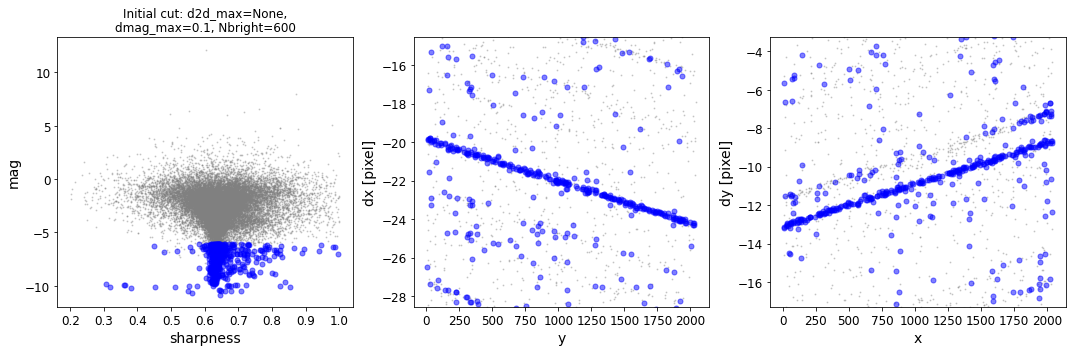

In [6]:
# show the initial dx, dy, centered around their respective medians
# blue symbols: measurements that make the initial cut using d2d_max, dmag_max, Nbright
# small gray symbols: didn't make the initial cut.
# goal of the initial cuts is to remove enough of the faint, spurious matches so that the
# loci of the good matches sticks at least a little out (visually)
if showplots>1:
    sp = initplot(1,3)
    # plot the residuals
    title = f'Initial cut: d2d_max={d2d_max},\ndmag_max={dmag_max}, Nbright={Nbright}'
    wcs_align.phot.t.loc[wcs_align.phot.ixs_notuse].plot('sharpness','mag',ax=sp[0],**plot_style['do_not_use_data'])
    wcs_align.phot.t.loc[wcs_align.phot.ixs_use].plot('sharpness','mag',ax=sp[0],ylabel='mag',title=title,**plot_style['good_data'])
    wcs_align.phot.t.loc[wcs_align.phot.ixs_notuse].plot('y','dx',ax=sp[1],ylim=dx_plotlim,**plot_style['do_not_use_data'])
    wcs_align.phot.t.loc[wcs_align.phot.ixs_use].plot('y','dx',ax=sp[1],ylim=dx_plotlim, ylabel='dx [pixel]',**plot_style['good_data'])
    wcs_align.phot.t.loc[wcs_align.phot.ixs_notuse].plot('x','dy',ax=sp[2],ylim=dx_plotlim,**plot_style['do_not_use_data'])
    wcs_align.phot.t.loc[wcs_align.phot.ixs_use].plot('x','dy',ax=sp[2],ylim=dy_plotlim,ylabel='dy [pixel]',**plot_style['good_data'])
    for i in range(3): sp[i].get_legend().remove()
    plt.tight_layout()
    plt.show()
 

hello
        slope     intercept        maxval  index  d_bestguess  fwhm  multimax
-4.882812e-03  5.000000e+00  38988.907994    672   -24.643247   0.3     False
-4.833984e-03  4.950000e+00  40319.395536    673   -24.529434   0.3     False
-4.785156e-03  4.900000e+00  39140.150327    673   -24.515621   0.3     False
-4.736328e-03  4.850000e+00  39959.359227    673   -24.501809   0.3     False
-4.687500e-03  4.800000e+00  54890.020857    674   -24.387996   0.2     False
-4.638672e-03  4.750000e+00  39065.947167    674   -24.374184   0.4     False
-4.589844e-03  4.700000e+00  39454.601045    674   -24.360371   0.4     False
-4.541016e-03  4.650000e+00  43249.999719    679   -23.846558   0.2     False
-4.492188e-03  4.600000e+00  52122.679127    675   -24.232746   0.2     False
-4.443359e-03  4.550000e+00  43249.999719    679   -23.818933   0.2     False
-4.394531e-03  4.500000e+00  34669.815876    676   -24.105121   0.4     False
-4.345703e-03  4.450000e+00  50756.610519    676   -24.091


####################
### d_rotated cut
Keeping 260 out of 260, skippin 0 because of null values in columns d_rot_tmp
median: -22.074853
65.000000 percentile cut: max residual for cut: 0.075481
median: -22.081084
i:00 mean:-22.081084(0.003143) stdev:0.040734(0.002216) X2norm:1.00 Nchanged:0 Ngood:169 Nclip:91

mean: -22.073423
i:01 mean:-22.073423(0.003936) stdev:0.057976(0.002777) X2norm:1.00 Nchanged:49 Ngood:218 Nclip:42

mean: -22.072566
i:02 mean:-22.072566(0.004494) stdev:0.069333(0.003171) X2norm:1.00 Nchanged:21 Ngood:239 Nclip:21

mean: -22.072699
i:03 mean:-22.072699(0.004689) stdev:0.072939(0.003309) X2norm:1.00 Nchanged:4 Ngood:243 Nclip:17

mean: -22.073555
i:04 mean:-22.073555(0.004747) stdev:0.074005(0.003350) X2norm:1.00 Nchanged:1 Ngood:244 Nclip:16

mean: -22.073555
i:05 mean:-22.073555(0.004747) stdev:0.074005(0.003350) X2norm:1.00 Nchanged:0 Ngood:244 Nclip:16
i:05 mean:-22.073555(0.004747) stdev:0.074005(0.003350) X2norm:1.00 Nchanged:0 Ngood:244 Nclip:16


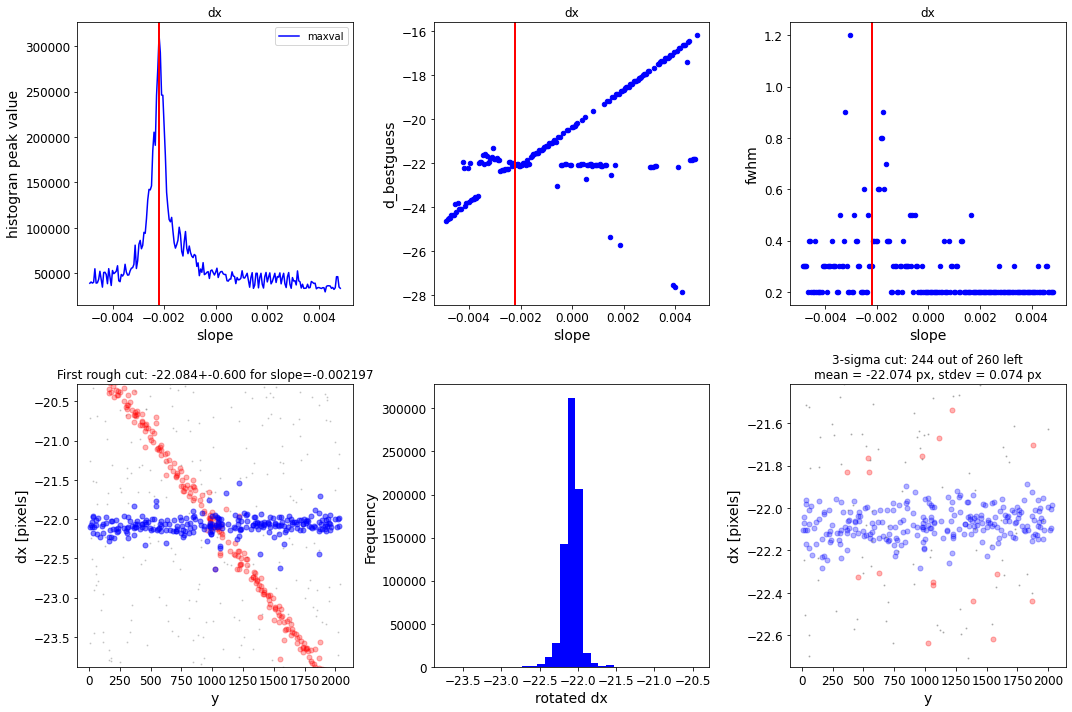

In [7]:
# first, do the dx cut, since dx does not have the same contamination by shadow locii due to 
# the star spikes than dy.
slope_max=-slope_min
slope_stepsize=(slope_max-slope_min)/slope_Nsteps

# initialize dx plot
if showplots>1:
    sp=initplot(2,3)
else:
    sp=None
(dx_rot_results,dx_best_index) = rotate_d_and_find_binmax(wcs_align.phot,ixs,'dx','y',
                                                          Ny,
                                                          binsize=binsize_px,
                                                          bin_weights_flag=bin_weights_flag,
                                                          slope_min=slope_min,
                                                          slope_max=slope_max,
                                                          slope_stepsize=slope_stepsize,
                                                          showplots=showplots,
                                                          sp=sp,
                                                          spi=[0,1,2])


# Using the best dx_rotated, we first remove all entries with dx_rotated outside of dx_bestguess+-Nfwhm*fwhm
# Note that FWHM ~ 2.355 stdev, so Nfwhm*fwhm should be at least 3*stdev. This is the first ROUGH cut, with 
# which we just want to remove excessive amounts of outliers. Then a 3-sigma cut is done on the *rotated* dx
(ixs_dx_cut,ixs_dx_roughcut) = sigmacut_d_rot(wcs_align.phot,ixs,'dx','y',
                                              dx_rot_results.t.loc[dx_best_index,'slope'],
                                              dx_rot_results.t.loc[dx_best_index,'intercept'],
                                              dx_rot_results.t.loc[dx_best_index,'d_bestguess'],
                                              rough_cut_px = Nfwhm*dx_rot_results.t.loc[dx_best_index,'fwhm'],
                                              binsize=binsize_px,
                                              bin_weights_flag=bin_weights_flag,
                                              showplots=showplots,
                                              sp=sp,
                                              spi=[3,4,5]
                                              )
plt.tight_layout()        

# top plots: histogram peak value, best guess of rotated dx offset, and fwhm with respect to the slopes.
# The red line indicates the best slope
# bottom plots:
# first rough cut is best guess of rotated dx offset +- Nfwhm*fwhm
# bottom left: red is dx, blue is the best rotated dx. small gray circles did not make initial cut
# bottom middle: histogram of rotated dx: this peak value should be the same as the peak in top left plot
# bottom right: 3-sigma cut getting rid of outliers still in the rough cut

hello
   slope  intercept        maxval  index  d_bestguess  fwhm  multimax
0.001709      -1.75 105295.692254    110   -10.734194   0.5     False
0.001758      -1.80  96458.460971    110   -10.766324   1.0     False
0.001807      -1.85 118990.705394    111   -10.698454   0.8     False
0.001855      -1.90 131845.329826    111   -10.730583   0.7     False
0.001904      -1.95 141061.562845    111   -10.762713   0.6     False
0.001953      -2.00 162987.476232    111   -10.794843   0.5     False
0.002002      -2.05 229179.999293    111   -10.826973   0.4     False
0.002051      -2.10 283830.125056    111   -10.859103   0.4     False
0.002100      -2.15 337153.409365    111   -10.891232   0.3     False
0.002148      -2.20 297616.995265    112   -10.823362   0.3     False
0.002197      -2.25 316489.259535    112   -10.855492   0.3     False
0.002246      -2.30 225412.380349    112   -10.887622   0.4     False
0.002295      -2.35 205850.578028    113   -10.819752   0.4     False
0.002344      

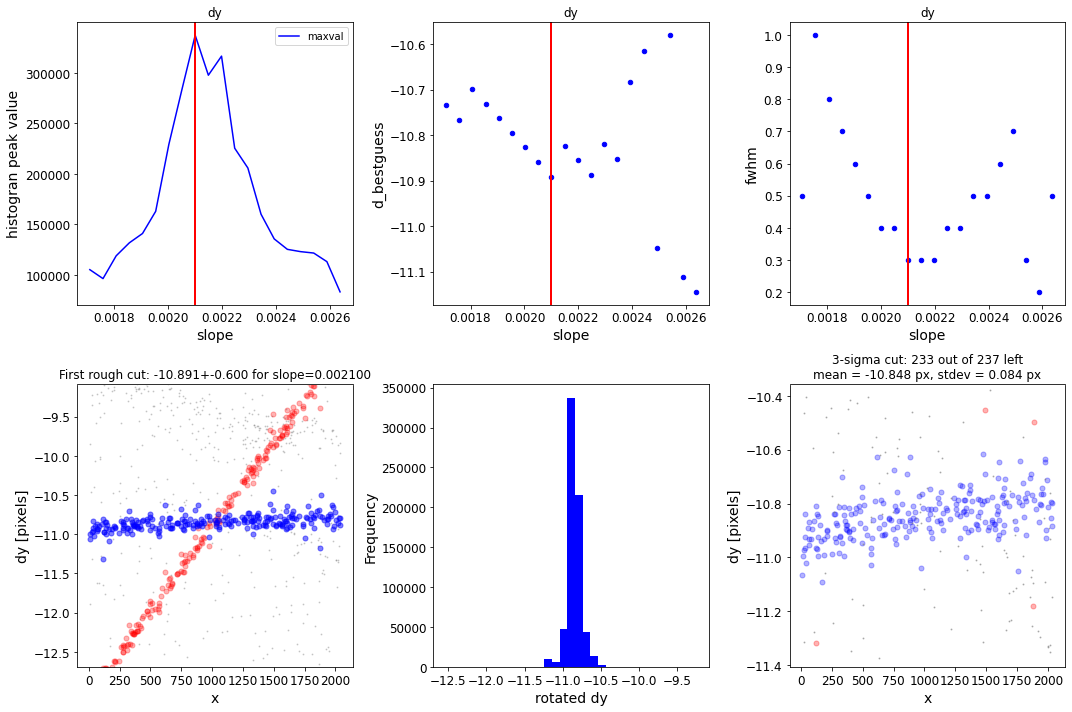

In [8]:
# Using the indices after the dx cut, we now also do a dy cut
# slope in dy is the -slope of dx.
slope = -dx_rot_results.t.loc[dx_best_index,'slope']
# We only need to do it +-10*stepsize
slope_min = slope-10*slope_stepsize
slope_max = slope+10*slope_stepsize

# initialize dy plot
if showplots>1:
    sp=initplot(2,3)
else:
    sp=None
(dy_rot_results,dy_best_index) = rotate_d_and_find_binmax(wcs_align.phot,ixs_dx_cut,'dy','x',
                                                          Nx,
                                                          binsize=binsize_px,
                                                          bin_weights_flag=bin_weights_flag,
                                                          slope_min=slope_min,
                                                          slope_max=slope_max,
                                                          slope_stepsize=slope_stepsize,
                                                          showplots=showplots,
                                                          sp=sp,
                                                          spi=[0,1,2])
(ixs_dy_cut,ixs_dy_roughcut) = sigmacut_d_rot(wcs_align.phot,ixs_dx_cut,'dy','x',
                                              dy_rot_results.t.loc[dy_best_index,'slope'],
                                              dy_rot_results.t.loc[dy_best_index,'intercept'],
                                              dy_rot_results.t.loc[dy_best_index,'d_bestguess'],
                                              rough_cut_px = Nfwhm*dy_rot_results.t.loc[dy_best_index,'fwhm'],
                                              binsize=binsize_px,
                                              bin_weights_flag=bin_weights_flag,
                                              showplots=showplots,
                                              sp=sp,
                                              spi=[3,4,5]
                                              )
plt.tight_layout()        


In [9]:

if savephottable:
    print(f'Saving {outbasename}.good.phot.txt')
    wcs_align.phot.write(f'{outbasename}.good.phot.txt',indices=ixs_dy_cut)
    if savephottable>1:
        print(f'Saving {outbasename}.all.phot.txt')
        wcs_align.phot.write(f'{outbasename}.all.phot.txt')

#if showplots>1:
#    # get the bad data points
#    infoplots(wcs_align.phot,ixs_dy_cut,dy_plotlim=dy_plotlim,dx_plotlim=dx_plotlim)
            



Saving ./test_jwst_wcs_align/jw01018003001_02101_00001_nrca2_assignwcsstep.good.phot.txt
Saving ./test_jwst_wcs_align/jw01018003001_02101_00001_nrca2_assignwcsstep.all.phot.txt


In [11]:
# Now align to the reference catalog ONLY using the best matches after the dy cut
# This alignment is done using a hacked version of tweakreg by Justin Pierel: only the part of tweakreg
# is used that does the rshift (rotation+translation) FITTING (only the fitting, no matching! 
# It uses the matches from wcs_align.phot.t[ixs_bestmatch])
ixs_bestmatch = ixs_dy_cut
(runflag,tweakregfilename) = wcs_align.run_align2refcat(calimname,ixs=ixs_bestmatch,
                                                   overwrite=overwrite,skip_if_exists=skip_if_exists)
print('DONE!')


2022-06-14 13:20:43,830 - stpipe.TweakRegStep - INFO - TweakRegStep instance created.
2022-06-14 13:20:44,148 - stpipe.TweakRegStep - INFO - Step TweakRegStep running with args ([<ImageModel(2048, 2048) from jw01018003001_02101_00001_nrca2_assignwcsstep.fits>],).
2022-06-14 13:20:44,150 - stpipe.TweakRegStep - INFO - Step TweakRegStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './test_jwst_wcs_align', 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': False, 'catalog_format': 'ecsv', 'kernel_fwhm': 2.5, 'snr_threshold': 50, 'brightest': 1000, 'peakmax': None, 'enforce_user_order': False, 'expand_refcat': False, 'minobj': 50, 'searchrad': 0.5, 'use2dhist': True, 'separation': 9, 'tolerance': 0.7, 'xoffset': 0, 'yoffset': 0, 'fitgeometry': 'rshift', 'nclip': 3, 'sigma': 3.0, 'align_to_gaia': False, 'gaia_cat

./test_jwst_wcs_align/jw01018003001_02101_00001_nrca2_tweakregstep.fits
Setting output directory for tweakregstep.fits file to ./test_jwst_wcs_align
233 matches are passed to tweakreg rshift fitting
Fitting tweakreg fitgeometry=rshift to xy=x,y to ra,dec=gaia_ra,gaia_dec


2022-06-14 13:20:44,166 - stpipe.TweakRegStep - INFO - NUMBER OF IMAGES: 1
2022-06-14 13:20:44,173 - stpipe.TweakRegStep - INFO - Detected 233 sources in jw01018003001_02101_00001_nrca2_assignwcsstep.fits.
2022-06-14 13:20:44,208 - stpipe.TweakRegStep - INFO - 
2022-06-14 13:20:44,208 - stpipe.TweakRegStep - INFO - Number of image groups to be aligned: 1.
2022-06-14 13:20:44,209 - stpipe.TweakRegStep - INFO - Image groups:
2022-06-14 13:20:44,238 - stpipe.TweakRegStep - INFO - * Images in GROUP 'jw01018003001_02101_00001_nrca2_assignwcsstep':
2022-06-14 13:20:44,239 - stpipe.TweakRegStep - INFO -      jw01018003001_02101_00001_nrca2_assignwcsstep
2022-06-14 13:20:44,239 - stpipe.TweakRegStep - INFO - 
2022-06-14 13:20:44,242 - stpipe.TweakRegStep - INFO -  
2022-06-14 13:20:44,243 - stpipe.TweakRegStep - INFO - ***** tweakwcs.imalign.align_wcs() started on 2022-06-14 13:20:44.242897
2022-06-14 13:20:44,243 - stpipe.TweakRegStep - INFO -       Version 0.7.4
2022-06-14 13:20:44,244 - stp

DONE!


hello
Index(['aper_sum_4.3px', 'annulus_median_4.3px', 'aper_bkg_4.3px',
       'aper_sum_bkgsub_4.3px', 'flux_err_4.3px', 'mag', 'dmag', 'x', 'y',
       'sharpness', 'roundness1', 'roundness2', 'ra', 'dec', 'x_idl', 'y_idl',
       'gaia_ra', 'gaia_dec', 'gaia_x', 'gaia_y', 'gaia_x_idl', 'gaia_y_idl',
       'gaia_ID', 'gaia_ra_error', 'gaia_dec_error', 'gaia_g', 'gaia_g_err',
       'gaia_rp', 'gaia_rp_err', 'gaia_g_rp', 'gaia_d2d', 'dx', 'dy',
       '__weights', 'd_rot_tmp', '__tmp_residuals'],
      dtype='object')
Saving ./test_jwst_wcs_align/jw01018003001_02101_00001_nrca2_tweakregstep.phot.prewcs.png
Saving ./test_jwst_wcs_align/jw01018003001_02101_00001_nrca2_tweakregstep.good.phot.txt
hello
Index(['aper_sum_4.3px', 'annulus_median_4.3px', 'aper_bkg_4.3px',
       'aper_sum_bkgsub_4.3px', 'flux_err_4.3px', 'mag', 'dmag', 'x', 'y',
       'sharpness', 'roundness1', 'roundness2', 'ra', 'dec', 'x_idl', 'y_idl',
       'gaia_ra', 'gaia_dec', 'gaia_ID', 'gaia_ra_error', 'gaia_dec_

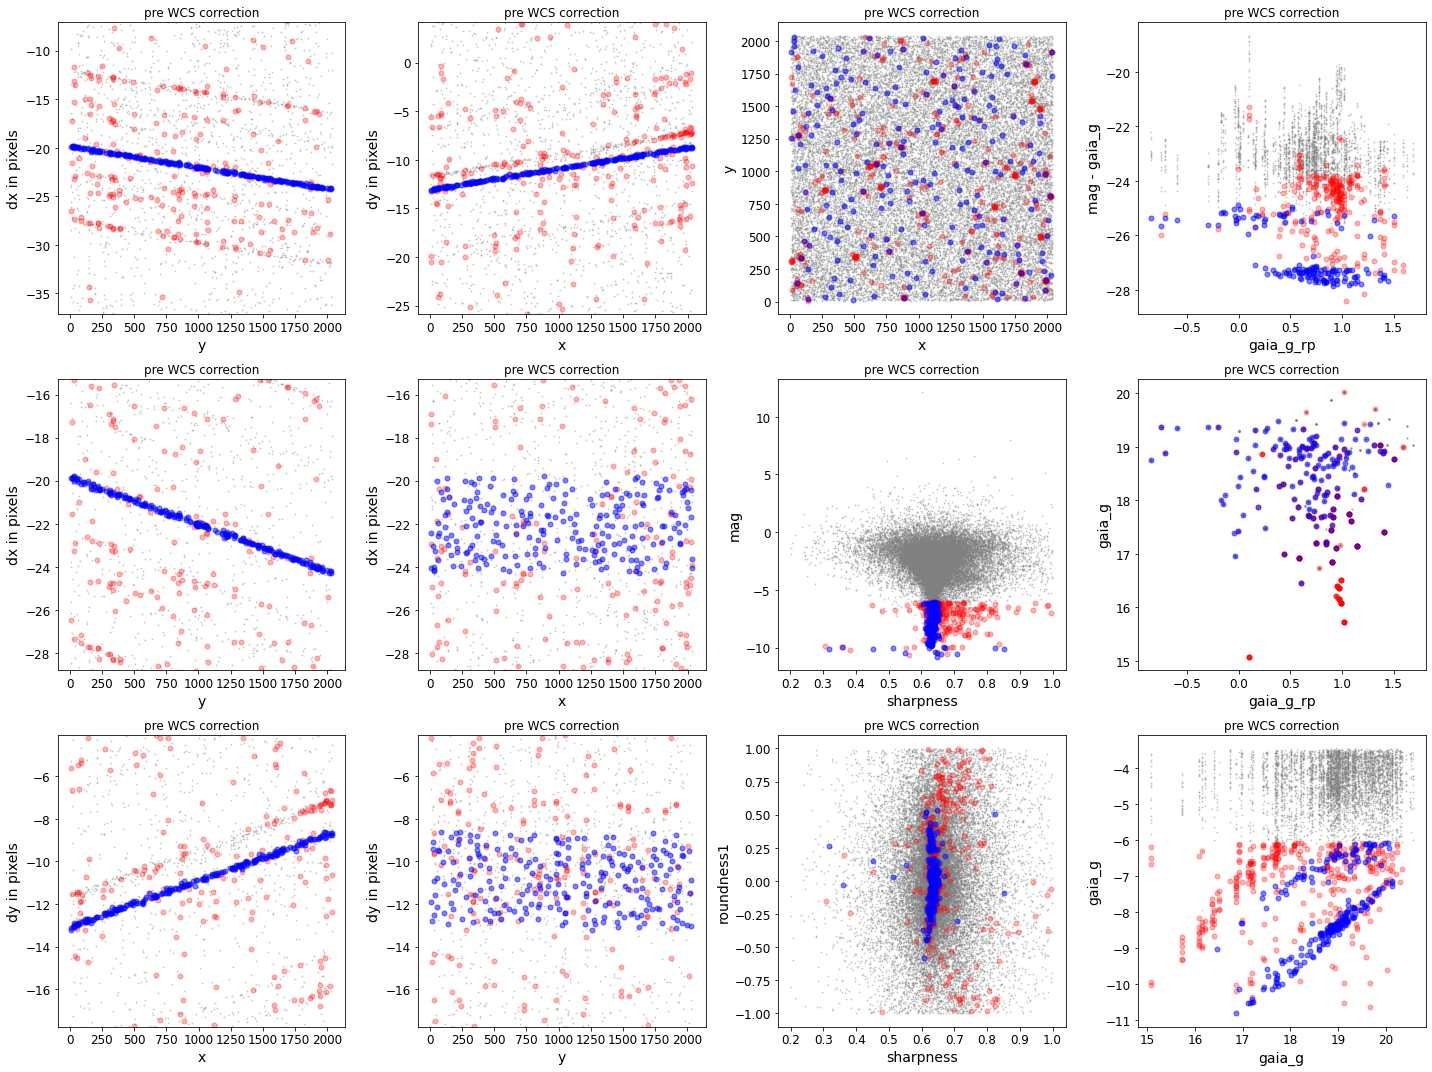

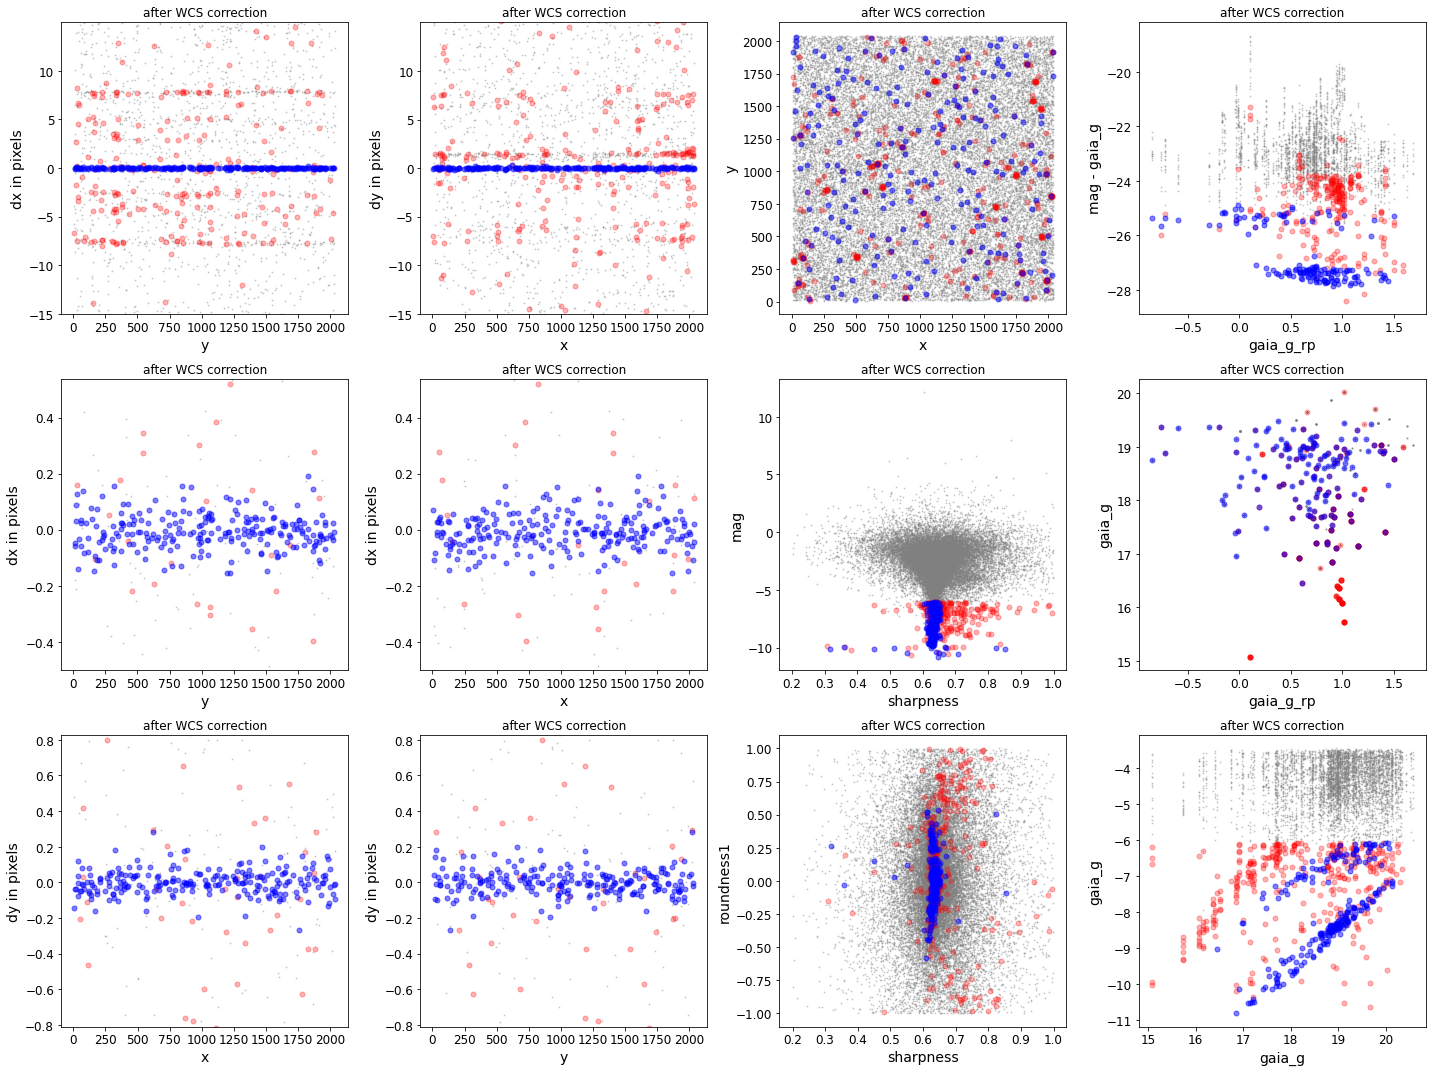

In [12]:

wcs_align.update_phottable_final_wcs(tweakregfilename,
                                ixs_bestmatch = ixs_bestmatch,
                                showplots=showplots,
                                saveplots=saveplots,
                                savephottable=savephottable,
                                overwrite=overwrite
                                )


In [ ]:
from pdastro import pdastroclass,pdastrostatsclass,makepath4file,unique,AnotB,AorB,AandB,rmfile
import numpy as np

# These are the info plots to check out dx, dy for good and bad detections
def infoplots(phot,ixs_good,dy_plotlim=(-4,4),dx_plotlim=(-4,4)):
    sp=initplot(2,3)

    if phot.ixs_notuse is not None:
        phot.t.loc[phot.ixs_notuse].plot('y','dx',ax=sp[0],ylim=dx_plotlim, **plot_style['do_not_use_data'])
        phot.t.loc[phot.ixs_notuse].plot('y','dx',ax=sp[0],ylim=dx_plotlim, **plot_style['do_not_use_data'])
        phot.t.loc[phot.ixs_notuse].plot('x','dy',ax=sp[1],ylim=dy_plotlim, **plot_style['do_not_use_data'])
        phot.t.loc[phot.ixs_notuse].plot('x','y',ax=sp[2],**plot_style['do_not_use_data'])
        phot.t.loc[phot.ixs_notuse].plot('sharpness','mag',ax=sp[3],**plot_style['do_not_use_data'])
        phot.t.loc[phot.ixs_notuse].plot('sharpness','dmag',ax=sp[4],**plot_style['do_not_use_data'])
        phot.t.loc[phot.ixs_notuse].plot('sharpness','roundness1',ax=sp[5],**plot_style['do_not_use_data'])

    if phot.ixs_use is not None:
        ixs_cut = AnotB(phot.ixs_use,ixs_good)
        print(len(ixs_good),len(ixs_cut),len(phot.ixs_use))
        phot.t.loc[ixs_cut].plot('y','dx',ax=sp[0],ylim=dx_plotlim, **plot_style['cut_data'])
        phot.t.loc[ixs_cut].plot('y','dx',ax=sp[0],ylim=dx_plotlim, **plot_style['cut_data'])
        phot.t.loc[ixs_cut].plot('x','dy',ax=sp[1],ylim=dy_plotlim, **plot_style['cut_data'])
        phot.t.loc[ixs_cut].plot('x','y',ax=sp[2],**plot_style['cut_data'])
        phot.t.loc[ixs_cut].plot('sharpness','mag',ax=sp[3],**plot_style['cut_data'])
        phot.t.loc[ixs_cut].plot('sharpness','dmag',ax=sp[4],**plot_style['cut_data'])
        phot.t.loc[ixs_cut].plot('sharpness','roundness1',ax=sp[5],**plot_style['cut_data'])


    
    phot.t.loc[ixs_good].plot('y','dx',ax=sp[0],ylim=dx_plotlim, ylabel='dx in pixels', **plot_style['good_data'])
    phot.t.loc[ixs_good].plot('x','dy',ax=sp[1],ylim=dy_plotlim, ylabel='dy in pixels', **plot_style['good_data'])
    phot.t.loc[ixs_good].plot('x','y',ax=sp[2],**plot_style['good_data'],ylabel='y')
    phot.t.loc[ixs_good].plot('sharpness','mag',ax=sp[3],**plot_style['good_data'],ylabel='mag')
    phot.t.loc[ixs_good].plot('sharpness','dmag',ax=sp[4],**plot_style['good_data'],ylabel='dmag')
    phot.t.loc[ixs_good].plot('sharpness','roundness1',ax=sp[5],**plot_style['good_data'],ylabel='roundness1')
    
    sp[4].set_ylim(0.0,0.15)

    for i in range(6): sp[i].get_legend().remove()
    
    plt.tight_layout()
    return(sp)

# plot the rotated dx or dy versus the original one
def plot_rotated(phot,ixs,d_col,col,
                 d_col_rot='d_rot_tmp',
                 sp=None,
                 spi=[0,1],
                 histolim=(-20,20),
                 bins=None,
                 bin_weights_flag=False,
                 title=None):
    if sp == None:
        sp=initplot(1,2)

    if phot.ixs_notuse is not None:
        phot.t.loc[phot.ixs_notuse].plot(col,d_col_rot,ax=sp[spi[0]],**plot_style['do_not_use_data'])
    phot.t.loc[ixs].plot(col,d_col,ax=sp[spi[0]],ylim=histolim,title=title,**plot_style['cut_data'])
    phot.t.loc[ixs].plot(col,d_col_rot,ax=sp[spi[0]],ylim=histolim,ylabel=f'{d_col} [pixels]',**plot_style['good_data'])
    sp[spi[0]].get_legend().remove()

    
    if bins is not None:
        if bin_weights_flag:
            phot.t.loc[ixs,d_col_rot].plot.hist(ax=sp[spi[1]],bins=bins,
                                                weights=phot.t.loc[ixs,'__weights'],
                                                xlim=histolim,color='blue')
        else:
            phot.t.loc[ixs,d_col_rot].plot.hist(ax=sp[spi[1]],bins=bins,xlim=histolim,color='blue')
        sp[spi[1]].set_xlabel(f'rotated {d_col}')
        #sp[spi[1]].get_legend().remove()
    return(sp)

def dxdy_plot(phot,ixs_selected, sp=None, spi = [0,1,4,5,8,9,2,6,10,3,7,11], title=None,
              refcat_mainfilter=None,refcat_mainfilter_err=None,refcat_maincolor=None):
    if sp is None: sp=initplot(3,4)

    dx_median = phot.t.loc[ixs_selected,'dx'].median()
    dy_median = phot.t.loc[ixs_selected,'dy'].median()

    dlim_big = 15
    #dlim_small= 1
    dx_ylim_big = (dx_median-dlim_big,dx_median+dlim_big)
    dy_ylim_big = (dy_median-dlim_big,dy_median+dlim_big)
    #dx_ylim_small = (dx_median-dlim_small,dx_median+dlim_small)
    #dy_ylim_small = (dy_median-dlim_small,dy_median+dlim_small)

    print(phot.t.columns)
    if (refcat_mainfilter is not None):
        if (refcat_mainfilter in phot.t.columns):
            phot.t['delta_mag'] = phot.t['mag'] - phot.t[refcat_mainfilter]
        else:
            print(f'Warning! cannot make plot with reference filter {refcat_mainfilter}, since it is not a column in the table')
    
    
    if phot.ixs_notuse is not None:
        phot.t.loc[phot.ixs_notuse].plot('y','dx',ax=sp[spi[0]], **plot_style['do_not_use_data'])
        phot.t.loc[phot.ixs_notuse].plot('x','dy',ax=sp[spi[1]], **plot_style['do_not_use_data'])
        phot.t.loc[phot.ixs_notuse].plot('y','dx',ax=sp[spi[2]], **plot_style['do_not_use_data'])
        phot.t.loc[phot.ixs_notuse].plot('x','dx',ax=sp[spi[3]], **plot_style['do_not_use_data'])
        phot.t.loc[phot.ixs_notuse].plot('x','dy',ax=sp[spi[4]], **plot_style['do_not_use_data'])
        phot.t.loc[phot.ixs_notuse].plot('y','dy',ax=sp[spi[5]], **plot_style['do_not_use_data'])
        phot.t.loc[phot.ixs_notuse].plot('x','y' ,ax=sp[spi[6]], **plot_style['do_not_use_data'])
        phot.t.loc[phot.ixs_notuse].plot('sharpness','mag',ax=sp[spi[7]], **plot_style['do_not_use_data'])
        phot.t.loc[phot.ixs_notuse].plot('sharpness','roundness1',ax=sp[spi[8]], **plot_style['do_not_use_data'])
        phot.t.loc[phot.ixs_notuse].plot(refcat_maincolor,'delta_mag',ax=sp[spi[9]], **plot_style['do_not_use_data'])
        phot.t.loc[phot.ixs_notuse].plot(refcat_maincolor,refcat_mainfilter,ax=sp[spi[10]], **plot_style['do_not_use_data'])
        phot.t.loc[phot.ixs_notuse].plot(refcat_mainfilter,'mag',ax=sp[spi[11]], **plot_style['do_not_use_data'])

    if phot.ixs_use is not None:
        ixs_cut = AnotB(phot.ixs_use,ixs_selected)
        phot.t.loc[ixs_cut].plot('y','dx',ax=sp[spi[0]], **plot_style['cut_data'])
        phot.t.loc[ixs_cut].plot('x','dy',ax=sp[spi[1]], **plot_style['cut_data'])
        phot.t.loc[ixs_cut].plot('y','dx',ax=sp[spi[2]], **plot_style['cut_data'])
        phot.t.loc[ixs_cut].plot('x','dx',ax=sp[spi[3]], **plot_style['cut_data'])
        phot.t.loc[ixs_cut].plot('x','dy',ax=sp[spi[4]], **plot_style['cut_data'])
        phot.t.loc[ixs_cut].plot('y','dy',ax=sp[spi[5]], **plot_style['cut_data'])
        phot.t.loc[ixs_cut].plot('x','y' ,ax=sp[spi[6]], **plot_style['cut_data'])
        phot.t.loc[ixs_cut].plot('sharpness','mag',ax=sp[spi[7]], **plot_style['cut_data'])
        phot.t.loc[ixs_cut].plot('sharpness','roundness1',ax=sp[spi[8]], **plot_style['cut_data'])
        phot.t.loc[ixs_cut].plot(refcat_maincolor,'delta_mag',ax=sp[spi[9]], **plot_style['cut_data'])
        phot.t.loc[ixs_cut].plot(refcat_maincolor,refcat_mainfilter,ax=sp[spi[10]], **plot_style['cut_data'])
        phot.t.loc[ixs_cut].plot(refcat_mainfilter,'mag',ax=sp[spi[11]], **plot_style['cut_data'])
        
    phot.t.loc[ixs_selected].plot('y','dx',ylim=dx_ylim_big,ax=sp[spi[0]],ylabel='dx in pixels',title=title, **plot_style['good_data'])
    phot.t.loc[ixs_selected].plot('x','dy',ylim=dy_ylim_big,ax=sp[spi[1]],ylabel='dy in pixels',title=title, **plot_style['good_data'])

    (dx_min,dx_max) = (phot.t.loc[ixs_selected,'dx'].min(),phot.t.loc[ixs_selected,'dx'].max())
    dx_ylim_small = (dx_min - 1.0*(dx_max - dx_min), dx_max + 1.0*(dx_max - dx_min))
    phot.t.loc[ixs_selected].plot('y','dx',ylim=dx_ylim_small,ax=sp[spi[2]],ylabel='dx in pixels',title=title, **plot_style['good_data'])
    phot.t.loc[ixs_selected].plot('x','dx',ylim=dx_ylim_small,ax=sp[spi[3]],ylabel='dx in pixels',title=title, **plot_style['good_data'])

    (dy_min,dy_max) = (phot.t.loc[ixs_selected,'dy'].min(),phot.t.loc[ixs_selected,'dy'].max())
    dy_ylim_small = (dy_min - 1.0*(dy_max - dy_min), dy_max + 1.0*(dy_max - dy_min))
    phot.t.loc[ixs_selected].plot('x','dy',ylim=dy_ylim_small,ax=sp[spi[4]],ylabel='dy in pixels',title=title, **plot_style['good_data'])
    phot.t.loc[ixs_selected].plot('y','dy',ylim=dy_ylim_small,ax=sp[spi[5]],ylabel='dy in pixels',title=title, **plot_style['good_data'])

    phot.t.loc[ixs_selected].plot('x','y',ax=sp[spi[6]],ylabel='y',title=title, **plot_style['good_data'])
    phot.t.loc[ixs_selected].plot('sharpness','mag',ax=sp[spi[7]],ylabel='mag',title=title, **plot_style['good_data'])
    phot.t.loc[ixs_selected].plot('sharpness','roundness1',ax=sp[spi[8]],ylabel='roundness1',title=title, **plot_style['good_data'])
    phot.t.loc[ixs_selected].plot(refcat_maincolor,'delta_mag',ax=sp[spi[9]],ylabel=f'mag - {refcat_mainfilter}',title=title, **plot_style['good_data'])
    phot.t.loc[ixs_selected].plot(refcat_maincolor,refcat_mainfilter,ax=sp[spi[10]],ylabel=f'{refcat_mainfilter}',title=title, **plot_style['good_data'])
    phot.t.loc[ixs_selected].plot(refcat_mainfilter,'mag',ax=sp[spi[11]],ylabel=f'{refcat_mainfilter}',title=title, **plot_style['good_data'])

    for i in range(12): 
        if sp[spi[i]].get_legend() is not None:
            sp[spi[i]].get_legend().remove()

    plt.tight_layout()
    return(sp)

# find the maximum value in yvals, its index, and the corresponding value in xvals
# also indicate if there are multiple entries with the same maximum value (multiple_max=True)
def find_info_for_maxval(xvals,yvals,use_firstindex_if_multiple=True):
    # get the max value of the histogram, and its associated bin
    #print(histo)
    maxval = np.max(yvals)
    ixs_max = np.where(yvals==maxval)
    multiple_max = None
    if (len(ixs_max[0])==0):
        raise RuntimeError('BUUUUGGGG!!!!')
    elif (len(ixs_max[0])>1):
        if not use_firstindex_if_multiple:
            raise RuntimeError(f'More than one indices {ixs_max} for maxval={maxval}')
        #print(f'\nWARNING!! More than one indices {ixs_max} for maxval={maxval}!')
        multiple_max=True
        ix_best=ixs_max[0][0]
    else:
        multiple_max=False
        ix_best=ixs_max[0][0]
    # return ()
    
    # get the (rough) fwhm of the peak
    ix_minus = ix_best-1 
    if ix_minus<0: ix_minus=0
    ix_plus = ix_best+1
    if ix_plus>len(yvals)-1: ix_plus=len(yvals)-1
    while (ix_minus>0):
        if yvals[ix_minus]<=0.5*yvals[ix_best]:
            break
        ix_minus-=1
    while (ix_plus<len(yvals)-1):
        if yvals[ix_plus]<=0.5*yvals[ix_best]:
            break
        ix_plus+=1
    fwhm = xvals[ix_plus]-xvals[ix_minus]
    
    return(xvals[ix_best],yvals[ix_best],ix_best,fwhm,multiple_max)

# straight line. Sloppy: use global slope and intercept
def f(val,slope,intercept):
    return(val*slope+intercept)

def rotate_d_and_find_binmax(phot,ixs,d_col,col,
                             Naxis_px, # Nx or Ny, depending on col
                             d_col_rot='d_rot_tmp',
                             binsize=0.5,
                             bin_weights_flag=True,
                             slope_min=-10.0/2048.0, # 
                             slope_max=10.0/2048.0, # 
                             slope_stepsize=1.0/2048,
                             showplots=0,
                             sp=None,
                             spi=[0,1,2]):
    rot_results = pdastroclass()

    if bin_weights_flag:
        phot.t.loc[ixs,'__weights']=10**(-0.4*phot.t.loc[ixs,'mag'])
    else:
        phot.t.loc[ixs,'__weights']=None
        
    slopes = np.arange(slope_min,slope_max,slope_stepsize)
    for slope in slopes:
        #slope = delta4slope_pix/Nx
        intercept = -0.5*Naxis_px * slope

        #phot.t.loc[ixs,d_col_rot] = phot.t.loc[ixs,d_col] - f(phot.t.loc[ixs,col],slope,intercept)
        phot.t[d_col_rot] = phot.t[d_col] - f(phot.t[col],slope,intercept)

        # get the histogram
        d_rotated = phot.t.loc[ixs,d_col_rot]
        bins = np.arange(np.min(d_rotated),np.max(d_rotated),binsize)
        if bin_weights_flag:
            histo = np.histogram(d_rotated,bins=bins,weights=phot.t.loc[ixs,'__weights'])
        else:
            histo = np.histogram(d_rotated,bins=bins)
        #sp = plt.subplot(111)
        #print(histo[1])
        #sp.plot(histo[1][1:], histo[0], 'ro')
        # get the max value of the histogram, and its associated bin center. Note that the bincenter is 
        # the value in the bins (left edge of the bin) + the half of the binsize
        (bincenter4maxval,maxval,index_maxval,fwhm,multiple_max) = find_info_for_maxval(histo[1]+0.5*binsize,histo[0])

        # Save the results
        rot_results.newrow({'slope':slope,
                            'intercept':intercept,
                            'maxval':maxval,
                            'index':index_maxval,
                            'd_bestguess':bincenter4maxval,
                            'fwhm':fwhm,
                            'multimax':multiple_max
                            })
        # plot it if wanted
        if showplots>2:
            plot_rotated(phot,ixs,
                         d_col,col,
                         d_col_rot=d_col_rot,
                         bins=bins,
                         bin_weights_flag=bin_weights_flag,
                         histolim = (bincenter4maxval-8,bincenter4maxval+8),
                         title=f'slope:{slope}')
        #sys.exit(0)

    # print the results        
    rot_results.write()
    
    # find the best rotation
    maxmaxval = np.max(rot_results.t['maxval'])
    ixs_maxmax = np.where(rot_results.t['maxval']==maxmaxval)
    if (len(ixs_maxmax[0])==0):
        raise RuntimeError('BUUUUGGGG!!!!')
    elif (len(ixs_maxmax[0])>1):
        #print(f'\nWARNING!! more than one bin with maxvalue={maxmaxval}!')
        multiple_max=True
        best_index=ixs_maxmax[0][0]
    else:
        multiple_max=False
        best_index=ixs_maxmax[0][0]
    print('####BEST:')
    rot_results.write(indices=[best_index])
    
    if showplots>1:
        if sp is None:
            sp = initplot(1,3)
        rot_results.t.plot('slope','maxval',ax=sp[spi[0]],color='blue',title=f'{d_col}',ylabel='histogran peak value')
        rot_results.t.plot.scatter('slope','d_bestguess',ax=sp[spi[1]],color='blue',title=f'{d_col}')
        rot_results.t.plot.scatter('slope','fwhm',ax=sp[spi[2]],color='blue',title=f'{d_col}')
        sp[spi[0]].axvline(rot_results.t.loc[best_index,'slope'],  color='red',linestyle='-', linewidth=2.0)
        sp[spi[1]].axvline(rot_results.t.loc[best_index,'slope'],  color='red',linestyle='-', linewidth=2.0)
        sp[spi[2]].axvline(rot_results.t.loc[best_index,'slope'],  color='red',linestyle='-', linewidth=2.0)
    
    
    return(rot_results,best_index)

def sigmacut_d_rot(phot,ixs,
                   d_col,col,
                   slope,intercept,d_rot_bestguess,
                   rough_cut_px = 2.5, #This is the first rough cut:  get rid of everything d_rot_bestguess+-rough_cut_px
                   d_col_rot='d_rot_tmp',
                   binsize=0.5,
                   bin_weights_flag=True,
                   showplots=0,
                   sp=None,
                   spi=[0,1,2]):

    ### recover the slope and intercept of the best binning
    phot.t.loc[ixs,d_col_rot] = phot.t.loc[ixs,d_col] - f(phot.t.loc[ixs,col],slope,intercept)
    
    # Now make the rough cut! only keep data for with dx_rotated within  d_rot_bestguess+-rough_cut_px
    ixs_roughcut = phot.ix_inrange(d_col_rot,d_rot_bestguess-rough_cut_px,d_rot_bestguess+rough_cut_px,indices=ixs)
    d_rotated = phot.t.loc[ixs,d_col_rot]
    
    if showplots>1:
        if sp is None:
            sp=initplot(1,3)

        bins = np.arange(np.min(d_rotated),np.max(d_rotated),binsize)
        plot_rotated(phot,ixs_roughcut,
                     d_col,col,
                     d_col_rot=d_col_rot,
                     sp=sp,
                     spi=spi[:2],
                     bins=bins,
                     bin_weights_flag=bin_weights_flag,
                     histolim = (d_rot_bestguess-3*rough_cut_px,d_rot_bestguess+3*rough_cut_px),
                     title=f'First rough cut: {d_rot_bestguess:.3f}+-{rough_cut_px:.3f} for slope={slope:.6f}')

    print('\n####################\n### d_rotated cut')
    #ixs_clean4average = phot_clear.ix_inrange(d_col,0,3,indices=ixs_clear_cut)
    phot.calcaverage_sigmacutloop(d_col_rot,verbose=3,indices=ixs_roughcut,percentile_cut_firstiteration=65)
    print(phot.statstring())
    ixs_cut = phot.statparams['ix_good']

    if showplots>1:
        title = f'3-sigma cut: {len(ixs_cut)} out of {len(ixs_roughcut)} left\n'
        title += f'mean = {phot.statparams["mean"]:.3f} px, stdev = {phot.statparams["stdev"]:.3f} px'
        phot.t.loc[AnotB(ixs_roughcut,ixs_cut)].plot(col,d_col_rot,style='o',ax=sp[spi[2]],color='red', ms=5 ,alpha=0.3,title=title)
        phot.t.loc[ixs_cut].plot(col,d_col_rot,style='o',ax=sp[spi[2]],color='blue', 
                                 ms=5 ,alpha=0.3,ylabel=f'{d_col} [pixels]',
                                 title=title)
        if phot.ixs_notuse is not None:
            phot.t.loc[phot.ixs_notuse].plot(col,d_col_rot,style='o',ax=sp[spi[2]],color='gray', ms=1,alpha=0.5)
        sp[spi[2]].get_legend().remove()
    
        # set the appropriate y-axis limits
        (ylim_min,ylim_max) = (phot.t.loc[ixs_roughcut,d_col_rot].min(),phot.t.loc[ixs_roughcut,d_col_rot].max())
        ylim_min -= 0.1*(ylim_max-ylim_min)
        ylim_max += 0.1*(ylim_max-ylim_min)
        sp[spi[2]].set_ylim(ylim_min,ylim_max)
        #sp[spi[2]].set_ylim(sp[spi[2]].get_ylim(),(ylim_min,ylim_max))
        
        
        #phot.t.loc[ixs_roughcut].plot.scatter(col,d_col_rot,ax=sp[spi[2]],color='red')
        #phot.t.loc[ixs_cut].plot.scatter(col,d_col_rot,ax=sp[spi[2]],color='blue',
        #                                 ylabel='dx in pixels',
        #                                 title=f'3-sigma cut: {len(ixs_cut)} out of {len(ixs_roughcut)} left')
    return(ixs_cut,ixs_roughcut)
